In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as f
import torch.optim as optim
import torchvision.transforms as transforms
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
image_dir = "/kaggle/input/medical-image-dataset/Dataset"

In [3]:
img_names = sorted(os.listdir(image_dir))

In [4]:
len(img_names)

120

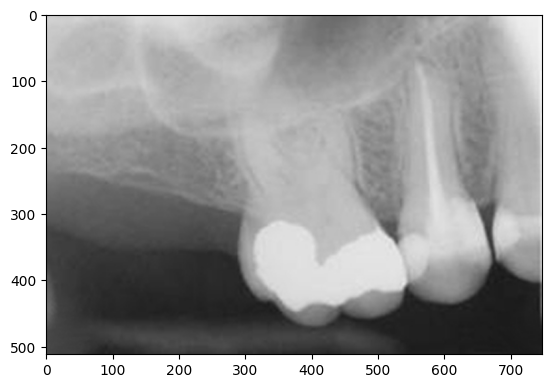

In [5]:
test_img = cv2.imread(os.path.join(image_dir, img_names[10]))
plt.imshow(test_img)

In [6]:
test_img.shape

(512, 748, 3)

In [7]:
class NoisyImageDataset(Dataset):
    def __init__(self, image_dir, img_names, noise_level_range=(0.1, 0.3)):
        self.image_dir = image_dir
        self.img_names = img_names
        self.noise_level_range = noise_level_range
        self.transform = transforms.Compose([
            transforms.Resize((512, 736)),
            transforms.ToTensor()
        ])


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("L")
        original_image = self.transform(image)

        # randomize noise level
        noise_level = random.uniform(self.noise_level_range[0], self.noise_level_range[1])

        # adding noise
        noisy_image = original_image.clone()
        noisy_image += self.add_random_noise(noisy_image, noise_level)

        return noisy_image, original_image

    def add_random_noise(self, image, noise_level):
        noise_type = random.choice(['gaussian', 'uniform'])
        
        if noise_type == 'gaussian':
            noise = torch.randn_like(image) * noise_level
        else:  # uniform noise
            noise = torch.rand_like(image) * noise_level
        
        return noise

In [8]:
dataset = NoisyImageDataset(image_dir, img_names)

In [9]:
len(dataset)

120

In [10]:
dataset[0][0].size()

torch.Size([1, 512, 736])

In [11]:
batch_size = 8

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
len(dataloader)

15

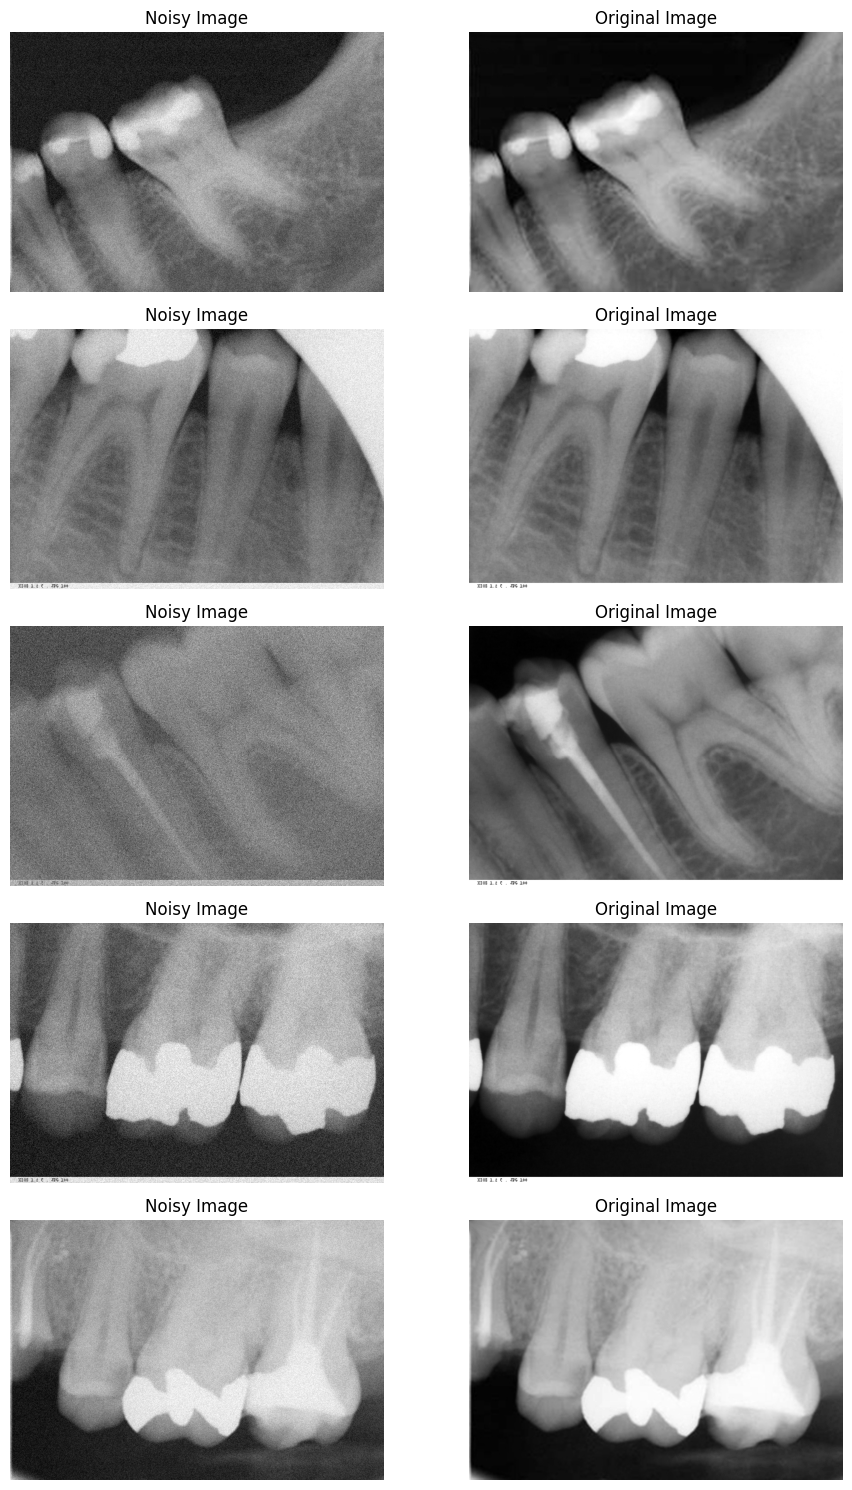

In [13]:
num_images_to_plot = 5
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(10, 15))

for i, (noisy_images, original_images) in enumerate(dataloader):
    for j in range(num_images_to_plot):
        noisy_image = noisy_images[j].permute(1, 2, 0).squeeze().numpy()
        original_image = original_images[j].permute(1, 2, 0).squeeze().numpy()
        
        # Plot noisy image
        axes[j, 0].imshow(noisy_image, cmap = "gray")
        axes[j, 0].set_title('Noisy Image')
        axes[j, 0].axis('off')
        
        # Plot original image (target)
        axes[j, 1].imshow(original_image, cmap = "gray")
        axes[j, 1].set_title('Original Image')
        axes[j, 1].axis('off')
        
    break  # Stop after first batch for demonstration

plt.tight_layout()
plt.show()

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # encoder layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(True)

        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv7 = nn.Conv2d(32 +16, 16, kernel_size=3, stride=1, padding=1)
        self.relu7 = nn.ReLU(True)
        self.upsample4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv8 = nn.Conv2d(16 + 1, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        """
        Input size: torch.Size([b, 1, 512, 736])
        Conv1 output size: torch.Size([b, 16, 256, 368])
        Conv2 output size: torch.Size([b, 32, 128, 184])
        Upsample3 output size: torch.Size([b, 32, 256, 368])
        Concatenated size after upsample3: torch.Size([b, 48, 256, 368])
        Conv7 output size: torch.Size([b, 16, 256, 368])
        Upsample4 output size: torch.Size([b, 16, 512, 736])
        Concatenated size after upsample4: torch.Size([b, 17, 512, 736])
        Conv8 output size: torch.Size([b, 1, 512, 736])
        Final output size: torch.Size([b, 1, 512, 736])
        """
        
        # encoder
        x1 = self.conv1(x)
        x1 = self.relu1(x1)
        x2 = self.conv2(x1)
        x2 = self.relu2(x2)
        
        # decoder
        x3 = self.upsample3(x2)
        x3 = torch.cat([x3, x1], dim=1)
        x4 = self.conv7(x3)
        x4 = self.relu7(x4)
        x5 = self.upsample4(x4)
        x5 = torch.cat([x5, x], dim=1)
        x6 = self.conv8(x5)
        x6 = self.sigmoid(x6)
        
        return x6

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
model = Autoencoder().to(device)

x = torch.randn(1, 1, 512, 736).to(device)

output = model(x)

print("Final output size:", output.size())

Final output size: torch.Size([1, 1, 512, 736])


In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [18]:
num_epochs = 200
for epoch in range(num_epochs):
    running_loss = 0.0
    print(f"Epoch [{epoch+1}]", end = '')
    for i, (noisy_images, original_images) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(noisy_images.to(device))
        loss = criterion(outputs, original_images.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 3 == 0:  # print every 3 mini-batches
            print('[%d, %5d] loss: %.6f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
        else:
            print("#", end='')

print('Finished Training')

Epoch [1][1,     1] loss: 0.007233
##[1,     4] loss: 0.015918
##[1,     7] loss: 0.015282
##[1,    10] loss: 0.016579
##[1,    13] loss: 0.017671
##Epoch [2][2,     1] loss: 0.005235
##[2,     4] loss: 0.017163
##[2,     7] loss: 0.016673
##[2,    10] loss: 0.016975
##[2,    13] loss: 0.014909
##Epoch [3][3,     1] loss: 0.005100
##[3,     4] loss: 0.014865
##[3,     7] loss: 0.016425
##[3,    10] loss: 0.015836
##[3,    13] loss: 0.015082
##Epoch [4][4,     1] loss: 0.004239
##[4,     4] loss: 0.016034
##[4,     7] loss: 0.013891
##[4,    10] loss: 0.015287
##[4,    13] loss: 0.014271
##Epoch [5][5,     1] loss: 0.004506
##[5,     4] loss: 0.015157
##[5,     7] loss: 0.015349
##[5,    10] loss: 0.013348
##[5,    13] loss: 0.013657
##Epoch [6][6,     1] loss: 0.004178
##[6,     4] loss: 0.012778
##[6,     7] loss: 0.013618
##[6,    10] loss: 0.015425
##[6,    13] loss: 0.012680
##Epoch [7][7,     1] loss: 0.004490
##[7,     4] loss: 0.013606
##[7,     7] loss: 0.012634
##[7,    10] lo

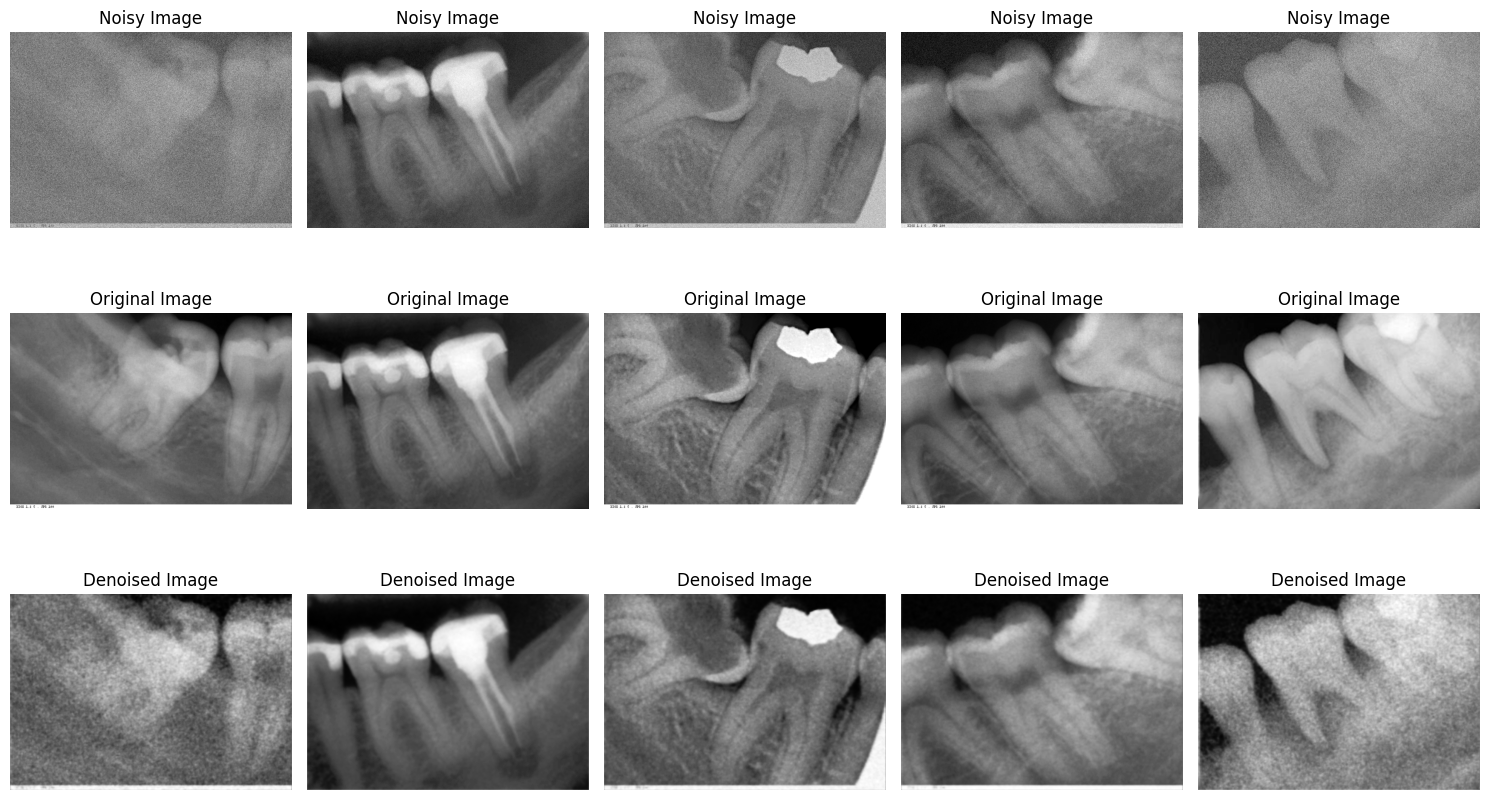

In [19]:
# Set the model to evaluation mode
model.eval()

# Get a batch of data from the train set
batch = next(iter(dataloader))

# Extract noisy images from the batch
noisy_images = batch[0][:5].to(device)  # Select the first 5 images in the batch
original_images = batch[1][:5].to(device)  # Corresponding original images

# Generate denoised images using the model
with torch.no_grad():
    denoised_images = model(noisy_images)
    denoised_images = denoised_images.view(-1, 1, 512, 736)  # Reshape to match the original image size

# Convert torch tensors to numpy arrays
noisy_images_np = noisy_images.cpu().numpy()
original_images_np = original_images.cpu().numpy()
denoised_images_np = denoised_images.cpu().numpy()

# Plot the images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

for i in range(5):
    # Plot noisy images
    axes[0, i].imshow(np.transpose(noisy_images_np[i], (1, 2, 0)), cmap="gray")
    axes[0, i].set_title('Noisy Image')
    axes[0, i].axis('off')
    
    # Plot original images
    axes[1, i].imshow(np.transpose(original_images_np[i], (1, 2, 0)), cmap="gray")
    axes[1, i].set_title('Original Image')
    axes[1, i].axis('off')
    
    # Plot denoised images
    axes[2, i].imshow(np.transpose(denoised_images_np[i], (1, 2, 0)), cmap="gray")
    axes[2, i].set_title('Denoised Image')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [20]:
weights_path = "unet_weights_2.pth"

torch.save(model.state_dict(), weights_path)

print("Model weights saved to:", weights_path)

Model weights saved to: unet_weights_2.pth


In [21]:
newmodel = Autoencoder().to(device)

In [22]:
newmodel.load_state_dict(torch.load('/kaggle/working/unet_weights_2.pth'))
newmodel.eval()

Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (upsample3): Upsample(scale_factor=2.0, mode='nearest')
  (conv7): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu7): ReLU(inplace=True)
  (upsample4): Upsample(scale_factor=2.0, mode='nearest')
  (conv8): Conv2d(17, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)

In [23]:
transform = transforms.Compose([
            transforms.Resize((512, 736)),
            transforms.ToTensor()
        ])

In [24]:
def add_random_noise(image, noise_level):
    """
    Add random noise to the input image.

    Args:
        image (torch.Tensor): The input image as a PyTorch tensor.
        noise_level (float): The level of noise to be added to the image.

    Returns:
        torch.Tensor: The noisy image.
    """
    noise_type = random.choice(['gaussian', 'uniform'])
    
    if noise_type == 'gaussian':
        noise = torch.randn_like(image) * noise_level
    else:  # uniform noise
        noise = torch.rand_like(image) * noise_level
    
    noisy_image = image + noise
    
    return noisy_image

In [25]:
def transform_to_tensor(image_path, transform):
    """
    Preprocess a grayscale image by applying a series of transformations.

    Args:
        image_path (str): The file path to the input grayscale image.
        transform (torchvision.transforms.Compose): The torchvision transform to be applied.

    Returns:
        torch.Tensor: The preprocessed image as a PyTorch tensor with batch dimension added.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image_pil = Image.fromarray(image)
    image_tensor = transform(image_pil)
    
    return image_tensor.unsqueeze(0)

In [26]:
test_tensor = transform_to_tensor("/kaggle/input/medical-image-dataset/Dataset/1.jpg",transform).to(device)
test_tensor.shape

torch.Size([1, 1, 512, 736])

In [27]:
test_tensor_with_noise = add_random_noise(test_tensor, 0.2)

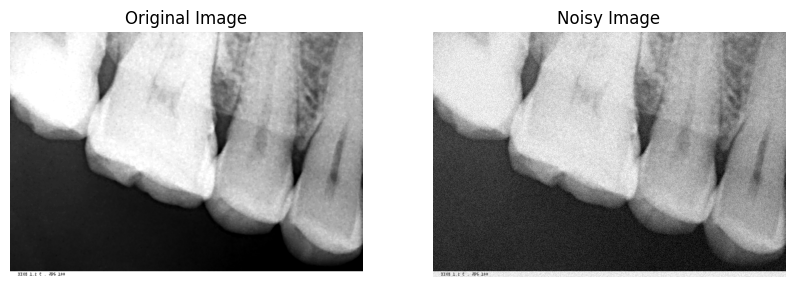

In [28]:
# original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_tensor.cpu().squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# noisy image
plt.subplot(1, 2, 2)
plt.imshow(test_tensor_with_noise.cpu().squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.show()

In [29]:
output_denoised = newmodel(test_tensor_with_noise)

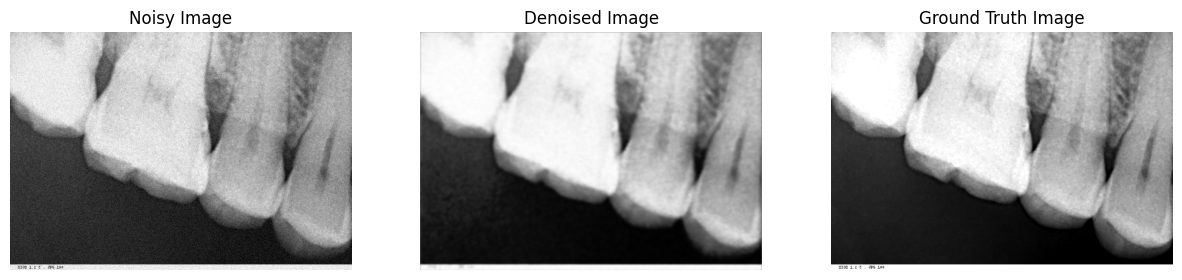

In [30]:
plt.figure(figsize=(15, 5))

# noisy image
plt.subplot(1, 3, 1)
plt.imshow(test_tensor_with_noise.cpu().squeeze(), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

# denoised image
plt.subplot(1, 3, 2)
plt.imshow(output_denoised.cpu().squeeze().detach().numpy(), cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

# ground truth image
plt.subplot(1, 3, 3)
plt.imshow(test_tensor.cpu().squeeze(), cmap='gray')
plt.title('Ground Truth Image')
plt.axis('off')

plt.show()